In [74]:
import xarray as xr
import pandas as pd

from pathlib import Path
from scipy.ndimage import label

import sys, os, re
import numpy as np      
from netCDF4 import Dataset    
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt       
from matplotlib.patches import Patch

from pyproj import Geod
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature         
import cartopy.io.shapereader as shpreader 

from matplotlib.colors import ListedColormap, BoundaryNorm

# WS extent

In [75]:
CONTEXT_LAT_MIN = 5
CONTEXT_LAT_MAX = 20
CONTEXT_LON_MIN = -20
CONTEXT_LON_MAX = -4

# Data loading

## Load core

In [76]:
def load_core(t):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    if year <= 2024:

        base = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}"
        fname = f"{year}{month}{day}{hour}{minute}.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][0]

            Pmax_lat = ds["max_lat"][:]
            Pmax_lon = ds["max_lon"][:]

        geo = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
        lons = geo["lon"]
        lats = geo["lat"]

    else:

        base = f"/gws/ssde/j25b/swift/rt_cores/{year}/{month}/{day}/{hour}{minute}"
        fname = f"Convective_struct_extended_{year}{month}{day}{hour}{minute}_000.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][:]

            Pmax_lat = ds["Pmax_lat"][:]
            Pmax_lon = ds["Pmax_lon"][:]

        geo = Dataset(
            "/gws/ssde/j25b/swift/rt_cores/geoloc_grids/"
            "nxny2268_2080_nxnyds164580_blobdx0.04491576_arean41_n27_27_79.nc"
        )
        lons = geo["lons_mid"][:]
        lats = geo["lats_mid"][:]
        geo.close()

    # ensure 1D arrays for matching
    Pmax_lat = np.asarray(Pmax_lat).ravel()
    Pmax_lon = np.asarray(Pmax_lon).ravel()

    return cores, lats, lons, Pmax_lat, Pmax_lon

## Load RDT

In [77]:
def load_rdt(t, domain="WestAfrica"):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    base = Path("/gws/ssde/j25b/swift/earajr/NWCSAF_archive/netcdf_2018/RDT")

    date = f"{year}{month}{day}"
    time = f"{hour}{minute}00"

    fname = f"S_NWC_RDT-CW_MSG4_{domain}-VISIR_{date}T{time}Z.nc"
    path = base / date / fname

    if not path.exists():
        return None, None, None, None

    with Dataset(path) as ds:

        rdt = {k: ds[k][:] for k in ds.variables}

        cat = ds["MapCellCatType"][:]
        lat = ds["lat"][:]
        lon = ds["lon"][:]

    return rdt, cat, lat, lon

# Load data for comparison

## Choose time

In [78]:
t = dict(year=2021, month=4, day=24, hour=22, minute=15)

## Load both data

In [79]:
data_core, lats_core, lons_core, Pmax_lat, Pmax_lon = load_core(t)
data_rdt, data_cat, lats_rdt, lons_rdt = load_rdt(t)

In [80]:
data_cat.shape

(1200, 1500)

## Plotting and overlay

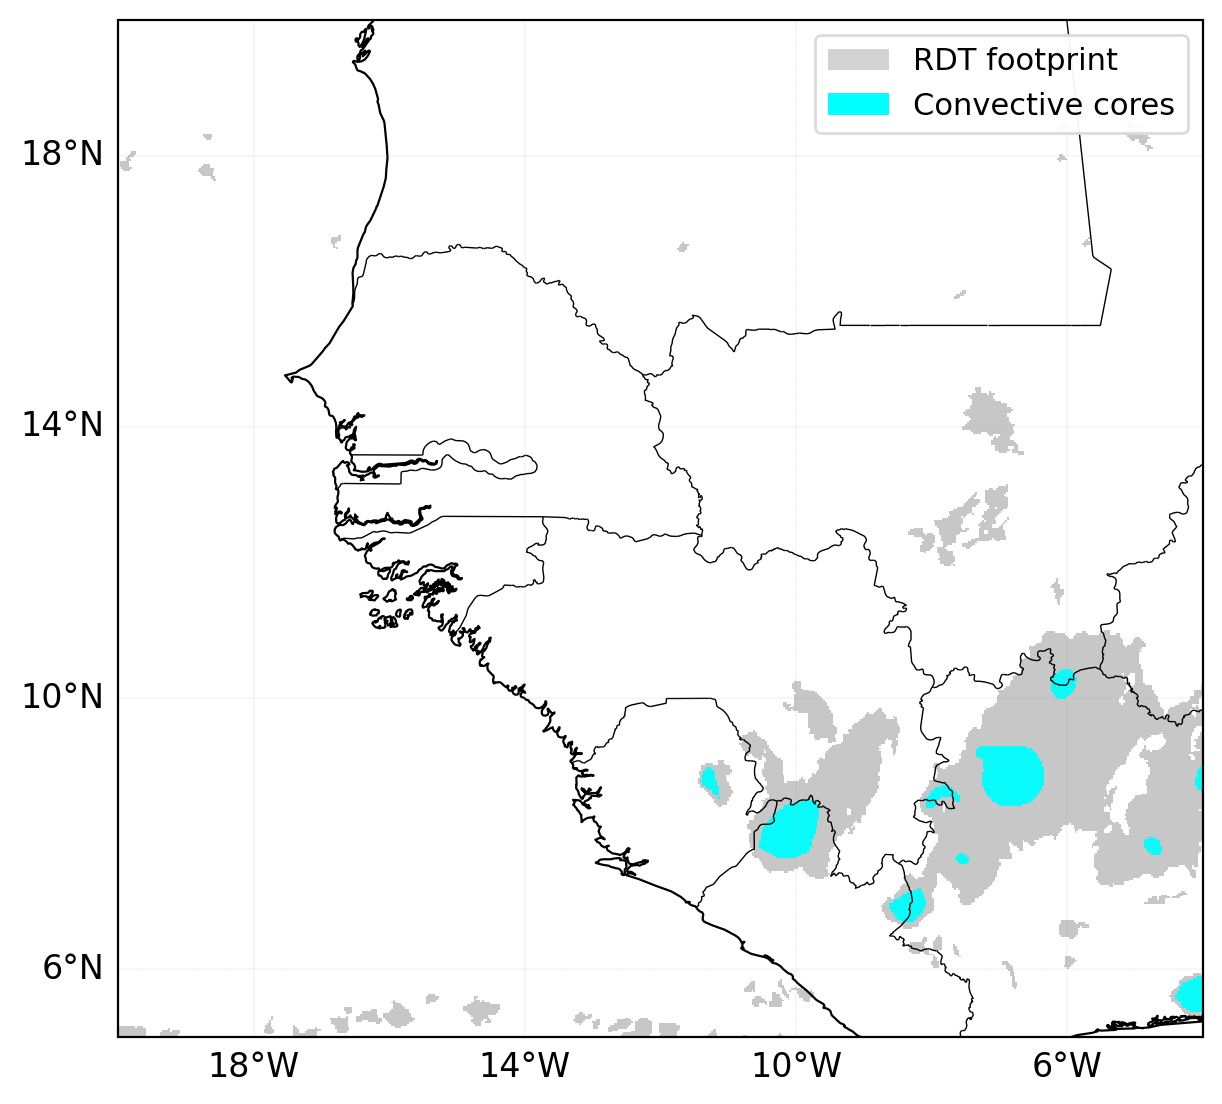

In [81]:
mask_rdt  = np.where(data_cat > 0, 1, np.nan)
mask_core = np.where(data_core > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1, 
                    xlocs=np.arange(-18, 6, 4),
                    ylocs=np.arange(6, 20, 4)
                    )

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


ax.pcolormesh(
    lons_rdt,
    lats_rdt,
    mask_rdt,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# cores very visible
ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj,
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RDT footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)


plt.show()

# Domain cropping

## Utilities for cropping

In [82]:
class GeoGrid:

    def __init__(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        fill_value=-999.999
    ):

        self.fill_value = fill_value

        self.lats, self.lons, self.area, self.y0, self.y1, self.x0, self.x1 = \
            self._crop_with_area(
                lats, lons,
                lat_min, lat_max,
                lon_min, lon_max
            )

        self.Ny, self.Nx = self.lats.shape

        points = np.column_stack([
            self.lats.ravel(),
            self.lons.ravel()
        ])

        self.tree = cKDTree(points)


    def _crop_with_area(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max
    ):

        lats_nan = np.where(lats == self.fill_value, np.nan, lats)
        lons_nan = np.where(lons == self.fill_value, np.nan, lons)

        mask = (
            (lats_nan >= lat_min) &
            (lats_nan <= lat_max) &
            (lons_nan >= lon_min) &
            (lons_nan <= lon_max)
        )

        rows = np.where(mask.any(axis=1))[0]
        cols = np.where(mask.any(axis=0))[0]

        y0, y1 = rows[0], rows[-1]
        x0, x1 = cols[0], cols[-1]

        lats_crop = lats[y0:y1+1, x0:x1+1]
        lons_crop = lons[y0:y1+1, x0:x1+1]

        R = 6371.0

        lat_rad = np.deg2rad(lats_crop)
        lon_rad = np.deg2rad(lons_crop)

        dlat = np.gradient(lat_rad, axis=0)
        dlon = np.gradient(lon_rad, axis=1)

        dy = R * dlat
        dx = R * np.cos(lat_rad) * dlon

        area = np.abs(dx * dy)

        return lats_crop, lons_crop, area, y0, y1, x0, x1


    def crop(self, field):
        return field[self.y0:self.y1+1, self.x0:self.x1+1]


    def query(self, lat, lon):
        _, idx = self.tree.query([lat, lon])
        return np.unravel_index(idx, (self.Ny, self.Nx))

    def query_many(self, lat, lon):
        pts = np.column_stack([lat, lon])
        _, idx = self.tree.query(pts)
        return np.unravel_index(idx, (self.Ny, self.Nx))


## Crop RDT and core data

In [83]:
extent = (
    CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
    CONTEXT_LON_MIN, CONTEXT_LON_MAX
)

grid_core = GeoGrid(lats_core, lons_core, *extent)
grid_rdt  = GeoGrid(lats_rdt,  lons_rdt,  *extent)

# crop data
data_core = grid_core.crop(data_core)
data_cat  = grid_rdt.crop(data_cat)

# use cropped coordinates from grid
lats_core = grid_core.lats
lons_core = grid_core.lons

lats_rdt  = grid_rdt.lats
lons_rdt  = grid_rdt.lons

In [84]:
data_cat.shape

(532, 578)

## Plot to check nothing is broken

(532, 578) (532, 578) (532, 578)


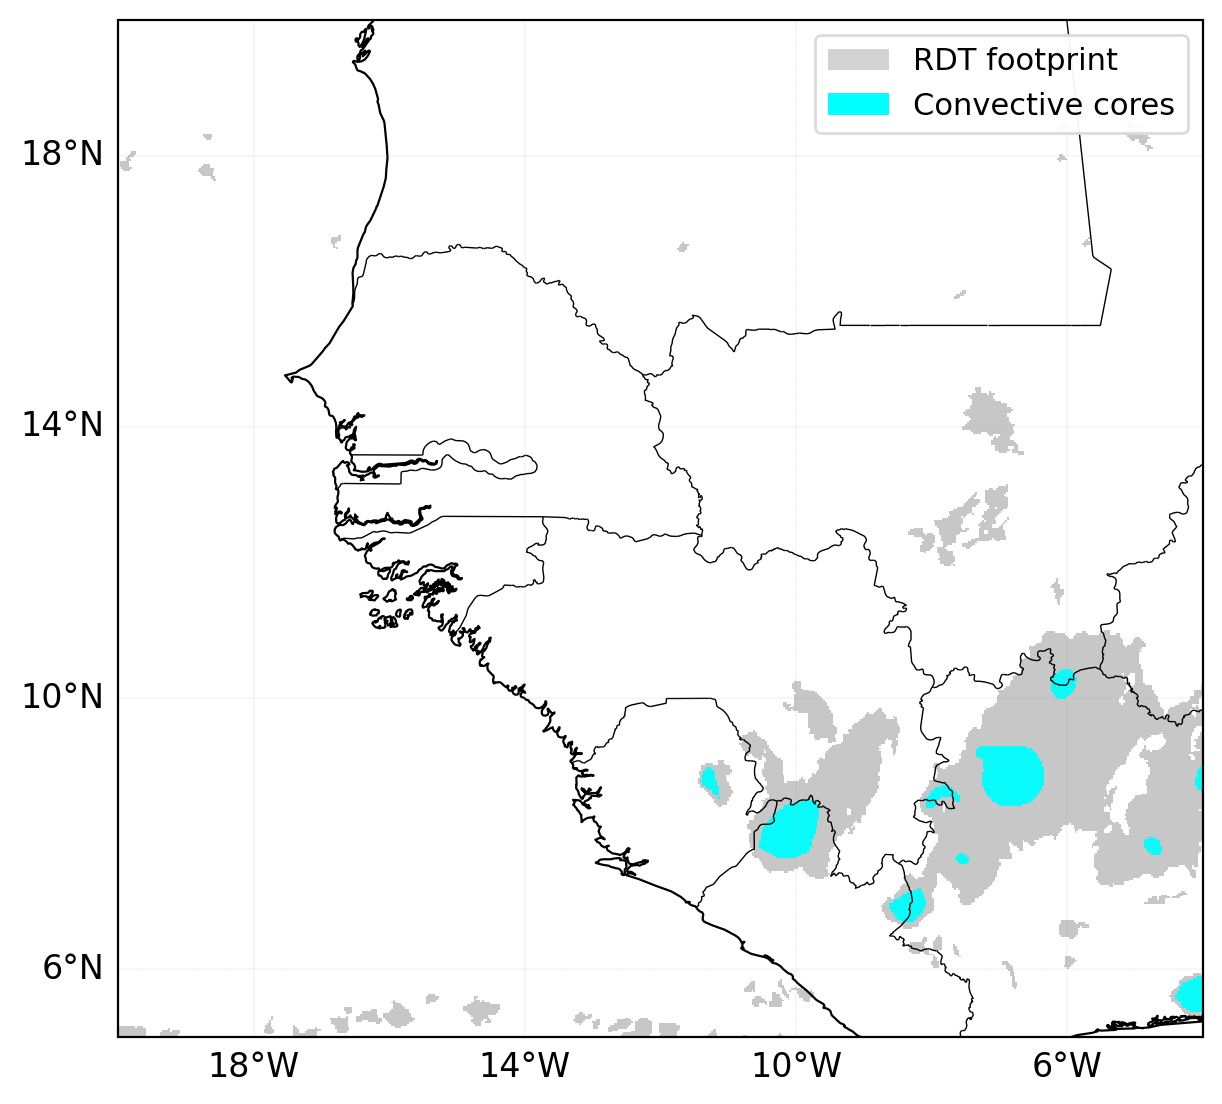

In [85]:
mask_rdt  = np.where(data_cat > 0, 1, np.nan)
mask_core = np.where(data_core > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1, 
                    xlocs=np.arange(-18, 6, 4),
                    ylocs=np.arange(6, 20, 4)
                    )

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


print(lons_rdt.shape, lats_rdt.shape, mask_rdt.shape)

ax.pcolormesh(
    lons_rdt,
    lats_rdt,
    mask_rdt,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# cores very visible
ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj,
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RDT footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)


plt.show()

# Object extraction

## RDT

In [86]:
def rdt_to_dataframe(cat, grid):

    labeled, n = label(cat > 0)

    rows = []

    for lab in range(1, n + 1):

        m = labeled == lab

        weights = grid.area[m]

        lat_vals = grid.lats[m]
        lon_vals = grid.lons[m]

        lat_centroid = float(np.average(lat_vals, weights=weights))
        lon_centroid = float(np.average(lon_vals, weights=weights))

        lat_min = float(lat_vals.min())
        lat_max = float(lat_vals.max())
        lon_min = float(lon_vals.min())
        lon_max = float(lon_vals.max())

        size_km2 = float(weights.sum())

        cat_type = int(np.bincount(cat[m].astype(int)).argmax())

        rows.append((
            lab,
            lat_centroid,
            lon_centroid,
            lat_min,
            lat_max,
            lon_min,
            lon_max,
            size_km2,
            cat_type
        ))

    return pd.DataFrame(
        rows,
        columns=[
            "label",
            "lat_centroid",
            "lon_centroid",
            "lat_min",
            "lat_max",
            "lon_min",
            "lon_max",
            "size",
            "cat_type"
        ]
    )


In [87]:
df_rdt = rdt_to_dataframe(data_cat, grid_rdt)

In [88]:
df_rdt

,label,lat_centroid,lon_centroid,lat_min,lat_max,lon_min,lon_max,size,cat_type
0,1,18.348881,-4.986915,18.176189,18.561024,-5.174103,-4.789368,867.084167,3
1,2,18.560167,-5.029765,18.559999,18.560337,-5.058627,-5.000901,29.966415,3
2,3,18.419256,-6.058402,18.389593,18.448996,-6.094317,-6.006351,100.063583,17
3,4,18.125385,-4.801373,18.087643,18.146612,-4.843137,-4.755907,69.575661,3
4,5,18.275810,-18.671627,18.239771,18.300581,-18.721571,-18.624018,109.079758,17
...,...,...,...,...,...,...,...,...,...
61,62,5.024044,-11.250192,4.968060,5.105011,-11.352610,-11.186165,226.269440,6
62,63,5.049547,-19.241570,5.005337,5.116347,-19.368046,-19.101070,363.300781,2
63,64,4.990269,-10.244444,4.964510,5.046857,-10.321745,-10.182863,140.562698,6
64,65,4.980357,-10.835557,4.966146,5.021224,-11.017651,-10.683299,206.866226,6


# Creating core database

In [89]:
def create_core_database(
    cores,
    grid,
    Pmax_lat,
    Pmax_lon,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):

    if not np.any(cores):
        return {}

    valid = (
        (Pmax_lon >= lon_min) & (Pmax_lon <= lon_max) &
        (Pmax_lat >= lat_min) & (Pmax_lat <= lat_max)
    )

    Pmax_lat = Pmax_lat[valid]
    Pmax_lon = Pmax_lon[valid]

    labeled, _ = label(cores != 0)

    core_database = {}

    for lab in np.unique(labeled):

        if lab == 0:
            continue

        m = labeled == lab

        size_km2 = float(grid.area[m].sum())
        intensity = float(np.nanmean(cores[m]))

        lat_vals = grid.lats[m]
        lon_vals = grid.lons[m]
        weights = grid.area[m]

        lat_centroid = float(np.average(lat_vals, weights=weights))
        lon_centroid = float(np.average(lon_vals, weights=weights))

        lat_min_obj = float(lat_vals.min())
        lat_max_obj = float(lat_vals.max())
        lon_min_obj = float(lon_vals.min())
        lon_max_obj = float(lon_vals.max())

        for lat, lon in zip(Pmax_lat, Pmax_lon):

            y, x = grid.query(lat, lon)

            if labeled[y, x] != lab:
                continue

            core_database[int(lab)] = {
                "lat_peak": float(lat),
                "lon_peak": float(lon),
                "lat_centroid": lat_centroid,
                "lon_centroid": lon_centroid,
                "lat_min": lat_min_obj,
                "lat_max": lat_max_obj,
                "lon_min": lon_min_obj,
                "lon_max": lon_max_obj,
                "wp": intensity,
                "size": size_km2
            }

            break

    return core_database

In [90]:
core_db = create_core_database(
    cores=data_core,
    grid=grid_core,
    Pmax_lat=Pmax_lat,
    Pmax_lon=Pmax_lon,
    lat_min=CONTEXT_LAT_MIN,
    lat_max=CONTEXT_LAT_MAX,
    lon_min=CONTEXT_LON_MIN,
    lon_max=CONTEXT_LON_MAX
)

df_core = pd.DataFrame.from_dict(core_db, orient="index").reset_index(names="label")

In [91]:
df_core

,label,lat_peak,lon_peak,lat_centroid,lon_centroid,lat_min,lat_max,lon_min,lon_max,wp,size
0,1,5.661771,-4.071578,5.625267,-4.094835,5.388179,5.880739,-4.397820,-3.799067,219.598662,2739.446045
1,2,6.879455,-8.392337,6.933071,-8.335747,6.714072,7.181456,-8.615443,-8.090025,184.016667,2240.913086
2,3,7.619820,-7.551203,7.627843,-7.547841,7.564499,7.702668,-7.634629,-7.467837,92.548387,289.231537
3,4,8.017236,-10.060499,8.052693,-10.074267,7.657777,8.486762,-10.531934,-9.675852,166.825243,6822.608398
4,5,7.831955,-4.777522,7.816801,-4.733494,7.693841,7.942202,-4.860477,-4.612068,115.586667,693.646240
5,6,8.450013,-8.012684,8.560777,-7.862887,8.394545,8.698364,-8.070211,-7.597711,119.043478,1078.745972
6,7,8.667288,-7.021047,8.872064,-6.829227,8.417155,9.277969,-7.338504,-6.359323,163.091782,8765.551758
7,8,8.772111,-11.319958,8.766635,-11.261614,8.521426,8.966326,-11.404532,-11.142097,201.511111,860.449585
8,10,10.246078,-6.059985,10.210265,-6.054659,9.995282,10.413270,-6.226930,-5.866050,92.719298,1606.102051


# Comparison

In [92]:
def nearest_centroid_distance(core_lat, core_lon, rdt_lat, rdt_lon):

    geod = Geod(ellps="WGS84")

    dists = np.empty(len(core_lat))

    for i, (lat, lon) in enumerate(zip(core_lat, core_lon)):

        _, _, dist_m = geod.inv(
            np.full_like(rdt_lon, lon),
            np.full_like(rdt_lat, lat),
            rdt_lon,
            rdt_lat
        )

        dists[i] = dist_m.min() / 1000.0  # km

    return dists

In [93]:
core_lat_c = np.array([v["lat_centroid"] for v in core_db.values()])
core_lon_c = np.array([v["lon_centroid"] for v in core_db.values()])

In [94]:
rdt_lat = df_rdt["lat_centroid"].values
rdt_lon = df_rdt["lon_centroid"].values

In [95]:
d_km = nearest_centroid_distance(
    core_lat_c,
    core_lon_c,
    rdt_lat,
    rdt_lon
)

## Fraction of cores inside RDT

In [96]:
mask_rdt = data_cat > 0

ys, xs = grid_rdt.query_many(core_lat_c, core_lon_c)

inside = mask_rdt[ys, xs]

fraction = inside.mean()

print("Fraction of cores inside RDT:", fraction)


Fraction of cores inside RDT: 1.0


every single convective core centroid lies inside an RDT storm footprint

## Cores per RDT object

In [97]:
labels, n = label(mask_rdt)

counts = []

for lab in range(1, n+1):
    counts.append(np.sum(labels[ys, xs] == lab))

counts = np.array(counts)

print("Mean cores per RDT:", counts.mean())


Mean cores per RDT: 0.13636363636363635


## Histogram of cores per RDT

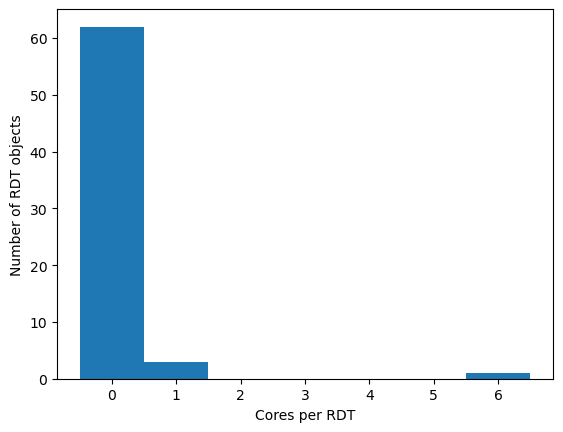

In [98]:
plt.hist(counts, bins=np.arange(0, counts.max()+2)-0.5)
plt.xlabel("Cores per RDT")
plt.ylabel("Number of RDT objects")
plt.show()

## Fraction of RDTs with ≥1 core

In [99]:
frac_active = np.mean(counts > 0)
print("Fraction of RDTs with cores:", frac_active)

Fraction of RDTs with cores: 0.06060606060606061


## Mean core per active RDT

In [100]:
mean_active = counts[counts > 0].mean()
print("Mean cores per active RDT:", mean_active)

Mean cores per active RDT: 2.25


In [101]:
df_rdt["n_cores"] = counts
stats = df_rdt.groupby("cat_type")["n_cores"].agg(
    ["count", "mean", "median", "max"]
)
print(stats)


          count      mean  median  max
cat_type                              
2            12  0.000000     0.0    0
3            15  0.000000     0.0    0
4             9  0.222222     0.0    1
5             1  6.000000     6.0    6
6            22  0.045455     0.0    1
17            7  0.000000     0.0    0


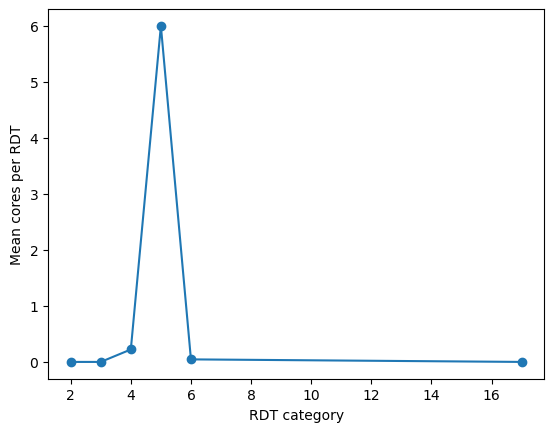

In [104]:
means = df_rdt.groupby("cat_type")["n_cores"].mean()

plt.plot(means.index, means.values, marker="o")

plt.xlabel("RDT category")
plt.ylabel("Mean cores per RDT")

plt.show()